# **I. Data**

In [1]:
data_path = "/content/drive/Othercomputers/내 컴퓨터/라벨이 지정되지 않은 볼륨[F]/교수님/PLS 양돈 농가/데이터/"

In [2]:
import pandas as pd
import numpy as np

### 원 데이터
odor = pd.read_csv(data_path + "New_data.csv", encoding="euc-kr")
odor = odor.drop(["yy", "mm", "dd", "farm"], axis = 1)    # 불필요한 변수 제거
odor.rename(columns = {"mm.1" : "mm"}, inplace = True)    # 추후 변수명을 편하게 사용하기 위해
print(odor.shape)
display(odor.head())

(57, 16)


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300.0,0.56,145.0,0.09,12.80,0.025,30.60,17.57,2.78,10.80,3.64,7.72,2.84,0.03,0.20,3.00
1,300.0,0.62,310.0,19.40,462.00,0.025,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448.0,0.97,90.5,0.04,63.90,0.025,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92
3,2080.0,1.02,344.0,0.04,13.00,0.630,490.79,570.61,51.09,719.27,168.48,237.64,8.90,60.56,5.55,7.31
4,310.0,1.18,312.0,0.04,0.04,0.025,404.53,468.03,43.17,573.75,157.22,205.67,9.21,69.90,0.20,5.43


## **1. Train and Test dataset**

In [28]:
def train_test_data(data, test_size, shuffle, random_state):
  from sklearn.model_selection import train_test_split

  X = data.iloc[:, 1:]
  y = data.loc[:, "ou"]

  train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = test_size, 
                                                      shuffle = shuffle, random_state = random_state)
  train_X = train_X.reset_index(drop=True)
  test_X = test_X.reset_index(drop=True)
  train_y = train_y.reset_index(drop=True)
  test_y = test_y.reset_index(drop=True)

  return {"train X" : train_X, "test X" : test_X, "train y" : train_y, "test y" : test_y}

## **2. StandardScaler**

In [29]:
def prepro(train_X, test_X, train_y, log_y, log_X) :
  from sklearn.preprocessing import StandardScaler
  import numpy as np

  if log_X == "yes" :
    train_X = np.log(train_X)
    test_X = np.log(test_X)
    std_scale = StandardScaler().fit(train_X)

    st_train_X = pd.DataFrame(std_scale.transform(train_X), columns = train_X.columns)
    st_test_X = pd.DataFrame(std_scale.transform(test_X), columns = test_X.columns)

  else :
    std_scale = StandardScaler().fit(train_X)

    st_train_X = pd.DataFrame(std_scale.transform(train_X), columns = train_X.columns)
    st_test_X = pd.DataFrame(std_scale.transform(test_X), columns = test_X.columns)

  train_y = train_y
  if log_y == "yes" : 
    train_y = np.log(train_y)

  return {"st train X" : st_train_X, "st test X" : st_test_X, "train y" : train_y}

# **II. 변수 추출법**

In [122]:
def VE_reg(train_X, train_y, test_X, random_state) : 

  import statsmodels.api as sm
  from tqdm.notebook import tqdm
  from sklearn.preprocessing import StandardScaler
  from sklearn import model_selection
  from sklearn.model_selection import RepeatedKFold
  from sklearn.metrics import mean_squared_error
  from sklearn.cross_decomposition import PLSRegression
  from sklearn.decomposition import PCA
  from itertools import accumulate

  #"""< Multiple Regression >""""
  const_train_X = sm.add_constant(train_X, has_constant = "add")
  mr = sm.OLS(train_y, const_train_X).fit()

  const_test_X = sm.add_constant(test_X, has_constant = "add")
  mr_pred = pd.DataFrame(mr.predict(const_test_X), columns = ["predict"])


  #"""< PLS >"""
  st_train_y = (train_y - train_y.mean()) / train_y.std()
  std = StandardScaler().fit(train_X)
  st_train_X = std.transform(train_X)
  st_test_X = std.transform(test_X)
  
  cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = random_state)
  mse = []
  for i in tqdm(np.arange(1, train_X.shape[1]+1)) :
      pls = PLSRegression(n_components = i)
      score = -1*model_selection.cross_val_score(pls, st_train_X, st_train_y, cv = cv,
                                                scoring = 'neg_mean_squared_error').mean()
      mse.append(score)

  pls_bc = mse.index(min(mse)) + 1     # Best Component

  pls = PLSRegression(n_components = pls_bc)
  pls_fit = pls.fit(st_train_X, st_train_y)
  pls_X = pd.DataFrame(pls_fit.transform(st_train_X), columns = ["comp " + str(i+1) for i in range(pls_bc)])
  pls_test_X = pd.DataFrame(pls_fit.transform(st_test_X), columns = ["comp " + str(i+1) for i in range(pls_bc)])

  const_pls_X = sm.add_constant(pls_X)
  pls_mr = sm.OLS(train_y, const_pls_X).fit()

  const_pls_test_X = sm.add_constant(pls_test_X)
  pls_mr_pred = pd.DataFrame(pls_mr.predict(const_pls_test_X), columns = ["predict"])


  #"""< PCA >"""
  pca = PCA(n_components = train_X.shape[1], random_state = 0).fit(st_train_X)
  cum_var = list(accumulate(pca.explained_variance_ratio_)) 
  pca_idx = np.where(np.array(cum_var) > 0.99)[0][0] + 1

  pca = PCA(n_components = pca_idx, random_state = 0).fit(st_train_X)
  pca_X = pca.transform(st_train_X)
  pca_X = pd.DataFrame(pca_X, columns = ["comp" + str(i) for i in range(pca_X.shape[1])])

  pca_test_X = pca.transform(st_test_X)
  pca_test_X = pd.DataFrame(pca_test_X, columns = ["comp" + str(i) for i in range(pca_test_X.shape[1])])

  const_pca_X = sm.add_constant(pca_X)
  pca_mr = sm.OLS(train_y, const_pca_X).fit()

  const_pca_test_X = sm.add_constant(pca_test_X)
  pca_mr_pred = pd.DataFrame(pca_mr.predict(const_pca_test_X), columns = ["predict"])

  return {"mr pred" : mr_pred, "pls mr pred" : pls_mr_pred, "pca mr pred" : pca_mr_pred,
          "pls bc" : pls_bc, "pca bc" : pca_idx}

# **III. 변수 선택법**

In [73]:
def VS_reg(train_X, train_y, test_X, random_state) : 

  import statsmodels.api as sm
  from sklearn.linear_model import RidgeCV
  from sklearn.linear_model import LassoCV
  from sklearn.linear_model import ElasticNetCV

  ### Ridge
  rdg = RidgeCV(alphas = [i*0.01 for i in range(1, 100)]).fit(train_X, train_y)
  rdg_pred = pd.DataFrame(rdg.predict(test_X), columns = ["predict"])


  ### Lasso
  las = LassoCV(alphas = [i*0.01 for i in range(1, 100)], random_state = random_state).fit(train_X, train_y)
  las_pred = pd.DataFrame(las.predict(test_X), columns = ["predict"])

  
  ### Elastic Net
  elas = ElasticNetCV(l1_ratio = [i*0.01 for i in range(1, 100)], alphas = [i*0.01 for i in range(1, 100)],
                      random_state = 99).fit(train_X, train_y)
  elas_pred = pd.DataFrame(elas.predict(test_X), columns = ["predict"])

  return {"ridge pred" : rdg_pred, "lasso pred" : las_pred, "elasticnet pred" : elas_pred}

# **IV. Machine Learning**

In [35]:
# !pip install optuna

In [147]:
def ML_hpo(train_X, train_y, test_X, verbose, random_state) :

  from sklearn.ensemble import RandomForestRegressor
  from sklearn.ensemble import ExtraTreesRegressor
  from xgboost import XGBRFRegressor
  import optuna
  from optuna import Trial, visualization
  from optuna.samplers import TPESampler              # TPESampler : TPE
  from optuna.integration import SkoptSampler         # SkoptSampler : Gaussian Process
  from sklearn.model_selection import cross_val_score
  from functools import partial


  # """< Random Forest >"""
  def optimize_rf(trial, X, y) :
    param = {"n_estimators" : trial.suggest_int("n_estimators", 100, 500),
            "max_depth" : trial.suggest_int("max_depth", 5, 20),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 5),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 6)
            } 

    model = RandomForestRegressor(**param)  
    rf_score = cross_val_score(model, X, y, cv = 10, scoring = "neg_mean_squared_error", verbose = verbose).mean()
  
    return  rf_score

  # """< Extremely Tree >"""
  def optimize_et(trial, X, y) :
    param = {"n_estimators" : trial.suggest_int("n_estimators", 100, 500),
            "max_depth" : trial.suggest_int("max_depth", 5, 20),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 5),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 6)
            } 

    model = ExtraTreesRegressor(**param)
    et_score = cross_val_score(model, X, y, cv = 10, scoring = "neg_mean_squared_error", verbose = verbose).mean()
    
    return  et_score

  # """< XGB >"""
  def optimize_xg(trial, X, y) :
    param = {"n_estimators" : trial.suggest_int("n_estimators", 100, 500),
            "max_depth" : trial.suggest_int("max_depth", 5, 20),
            "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 5),
            "min_samples_split" : trial.suggest_int("min_samples_split", 2, 6)
            } 

    model = XGBRFRegressor(**param)                   
    xg_score = cross_val_score(model, X, y, cv = 10, scoring = "neg_mean_squared_error", verbose = verbose).mean()
    return  xg_score


  ### Defining optimization_function as partial and calling optimize within it
  rf_optimization_function = partial(optimize_rf, X = train_X, y = train_y)
  et_optimization_function = partial(optimize_et, X = train_X, y = train_y)
  xg_optimization_function = partial(optimize_xg, X = train_X, y = train_y)
  study = optuna.create_study(direction = "maximize", sampler = TPESampler())

  ### Printing the best hyperparemeter set
  study.optimize(rf_optimization_function, n_trials = 15)
  rf_best_params = study.best_trial.params

  study.optimize(et_optimization_function, n_trials = 15)
  et_best_params = study.best_trial.params

  study.optimize(xg_optimization_function, n_trials = 15)
  xg_best_params = study.best_trial.params


  rf = RandomForestRegressor(**rf_best_params, random_state = random_state).fit(train_X, train_y)
  rf_pred = pd.DataFrame(rf.predict(test_X), columns = ["predict"])

  et = ExtraTreesRegressor(**et_best_params, random_state = random_state).fit(train_X, train_y)
  et_pred = pd.DataFrame(et.predict(test_X), columns = ["predict"])

  xg = XGBRFRegressor(**xg_best_params, random_state = random_state).fit(train_X, train_y)
  xg_pred = pd.DataFrame(xg.predict(test_X), columns = ["predict"])

  return {"rf pred" : rf_pred, "et pred" : et_pred, "xg pred" : xg_pred,
          "rf best params" : rf_best_params, "et best params" : et_best_params, "xg best params" : xg_best_params}

# **V. Neural Network**

In [160]:
def NN_hpo(train_X, train_y, test_X, epo, log_y, random_state) :
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Dense
  import tensorflow as tf
  from sklearn.neural_network import MLPRegressor
  from sklearn.model_selection import GridSearchCV

  # """< ANN >"""
  tf.random.set_seed(random_state)
  
  model = Sequential()
  model.add(Dense(10, input_dim = train_X.shape[1], activation = "relu"))
  model.add(Dense(1))
  model.compile(loss = "mean_squared_error",            # 손실함수
                optimizer = "adam",                     # 옵티마이저 설정
                metrics = ["mean_squared_error"])       # 모형 평가 지표

  model.fit(train_X, train_y, epochs = epo, verbose = 0)
  ann_pred = pd.DataFrame(model.predict(test_X), columns = ["predict"])
  

  mlp1_pred = []  ; mlp2_pred = []
  mlp1_best_params = [] ; mlp2_best_params = []

  if log_y == "no" : 
    # """< MLP 1 layer >"""
    mlp1 = MLPRegressor()
    mlp1_gs = GridSearchCV(mlp1, param_grid={'hidden_layer_sizes': [i for i in range(1,15)],
                                            'activation': ['relu', "tanh"],
                                            'solver': ['adam'],
                                            'learning_rate': ['constant'],
                                            'learning_rate_init': [0.001],
                                            'power_t': [0.5],
                                            'alpha': [0.0001],
                                            'max_iter': [10000],
                                            'early_stopping': [False],
                                            'warm_start': [False]})
    mlp1_gs.fit(train_X, train_y)
    mlp1_best_params = mlp1_gs.best_params_

    mlp1 = MLPClassifier(**mlp1_best_params, random_state = random_state).fit(train_X, train_y)
    mlp1_pred = pd.DataFrame(mlp1.predict(test_X), columns = ["predict"])

    # """< MLP 2 layers >"""
    mlp2 =MLPRegressor()
    mlp2_gs = GridSearchCV(mlp2, param_grid={'hidden_layer_sizes': [(i,j) for i in range(1,10) for j in range(1,10)],
                                            'activation': ['relu', "tanh"],
                                            'solver': ['adam'],
                                            'learning_rate': ['constant'],
                                            'learning_rate_init': [0.001],                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
                                            'power_t': [0.5],
                                            'alpha': [0.0001],
                                            'max_iter': [10000],
                                            'early_stopping': [False],
                                            'warm_start': [False]}) 

    mlp2_gs.fit(train_X, train_y)
    mlp2_best_params = mlp2_gs.best_params_
    mlp2 = MLPClassifier(**mlp2_best_params, random_state = random_state).fit(train_X, train_y)
    mlp2_pred = pd.DataFrame(mlp2.predict(test_X), columns = ["predict"])

  return {"ann pred" : ann_pred, "mlp1 pred" : mlp1_pred, "mlp2 pred" : mlp2_pred,
          "mlp1 best params" : mlp1_best_params, "mlp2 best params" : mlp2_best_params}

# **VI. Result Plot**

In [228]:
def Plot_odor(test_y, pred_list, log_y) :

  import statsmodels.api as sm
  import matplotlib.pyplot as plt
  from sklearn.metrics import r2_score


  def R2(true, pred) :
    import numpy as np
    sse = ((np.array(true) - np.array(pred))**2).sum()
    ssr = ((np.array(pred) - np.mean(true))**2).sum()
    sst = ((np.array(true) - np.mean(true))**2).sum()
    # r2 = 1 - (sse/sst)
    r2 = ssr/sst
    return np.round(r2, 3)

  def MAPE(true, pred) :
    import numpy as np
    mape = np.mean(np.abs((np.array(true) - np.array(pred)) / np.array(true))) * 100
    return np.round(mape, 3)

  def RMSE(true, pred) :
    import numpy as np
    mse = np.mean((np.array(true) - np.array(pred))**2)
    rmse = np.sqrt(mse)
    return np.round(rmse, 3)

  if log == "yes" :
    names = ["Multiple regression", "PLS regression", "PCA regression",
             "Ridge regression", "Lasso regression", "Elastic Net regression",
             "Random Forest", "Extremely Tree", "XGboost", 
             "ANN_sequential"]
    
    pred_list = [np.exp(pred_list[i]) for i in range(len(pred_list))]

  else :
    names = ["Multiple regression", "PLS regression", "PCA regression",
             "Ridge regression", "Lasso regression", "Elastic Net regression",
             "Random Forest", "Extremely Tree", "XGboost", 
             "ANN_sequential", "MLP 1 layer", "MLP 2 layer"]

    pred_list = pred_list

  

  plt.figure(figsize = (21, 28))
  for i in range(len(pred_list)) :
    const_pred_list = sm.add_constant(pred_list[i], has_constant = "add")
    pred_ols = sm.OLS(test_y, const_pred_list).fit()
    linear_x = range(0, 8000, 1000)
    linear_y = pred_ols.params[0] + pred_ols.params[1]*linear_x

    plt.subplot(4, 3, i+1)
    plt.scatter(test_y, pred_list[i])
    plt.plot(linear_x, linear_y, color = "darkred")
    plt.xlim(-2000, 7000) ; plt.ylim(-2000, 7000)
    plt.plot([0, 7000], [0, 7000], color = "black")
    plt.axhline(0, color = "grey", linestyle = "--")
    plt.axvline(0, color = "grey", linestyle = "--")
    plt.xlabel("Observed", fontsize = 15)  ; plt.ylabel("predict", fontsize = 15)
    plt.text(-1700,6500, names[i], 
            fontsize = 15, weight = "bold",
            bbox = dict(facecolor = 'ivory', edgecolor = 'black', boxstyle = 'round'))
    plt.text(-1700, 4500, 
            "y = " + str(np.round(pred_ols.params[0], 3)) + "+" + str(np.round(pred_ols.params[1], 3)) + "x" +
            "\nR2 (OLS) : " + str(np.round(pred_ols.rsquared, 3)) +
            "\nR2 (SSR/SST) : " + str(R2(test_y, pred_list[i])) +
            "\nRMSE : " + str(RMSE(test_y, pred_list[i])) +
            "\nMAPE : " + str(MAPE(test_y, pred_list[i])),
            fontsize = 15,
            bbox = dict(facecolor = 'white', edgecolor = 'none', boxstyle = 'round'))
    
  plt.tight_layout()
  plt.show()

# **Total**

In [169]:
def Analysis_odor(data, test_size, shuffle, random_state,
                  preprocess, log_y, log_X, epo) :

  tt_split = train_test_data(data = data, test_size = test_size, shuffle = shuffle, random_state = random_state)
  train_X = tt_split["train X"]
  test_X = tt_split["test X"]
  train_y = tt_split["train y"]
  test_y = tt_split["test y"]

  if preprocess == "yes" :
    pre = prepro(train_X = train_X, test_X = test_X, train_y = train_y, log = log)
    train_X = pre["st train X"]
    test_X = pre["st test X"]
    train_y = pre["train y"]

  ve = VE_reg(train_X = train_X, train_y = train_y, test_X = test_X, random_state = random_state)
  mr_pred = ve["mr pred"]
  pls_mr_pred = ve["pls mr pred"]
  pca_mr_pred = ve["pca mr pred"]
  pls_bc = ve["pls bc"] 
  pca_bc = ve["pca bc"] 

  vs = VS_reg(train_X = train_X, train_y = train_y, test_X = test_X, random_state = random_state)
  rdg_pred = vs["ridge pred"]
  las_pred = vs["lasso pred"]
  elas_pred = vs["elasticnet pred"]

  ml = ML_hpo(train_X = train_X, train_y = train_y, test_X = test_X, random_state = random_state)
  rf_pred = ml["rf pred"]
  et_pred = ml["et pred"]
  xg_pred = ml["xg pred"]
  rf_best_params = ml["rf best params"]
  et_best_params = ml["et best params"]
  xg_best_params = ml["xg best params"]

  nn = NN_hpo(train_X = train_X, train_y = train_y, test_X = test_X, log = log, epo = epo, random_state = random_state)
  ann_pred = nn["ann pred"]
  mlp1_pred = nn["mlp1 pred"]
  mlp2_pred = nn["mlp2 pred"]
  mlp1_best_params = nn["mlp1 best params"]
  mlp2_best_params = nn["mlp2 best params"]
  
  return {"mr pred" : mr_pred, "pls mr pred" : pls_mr_pred, "pca mr pred" : pca_mr_pred,
          "pls bc" : pls_bc, "pca bc" : pca_bc,
          "ridge pred" : rdg_pred, "lasso pred" : las_pred, "elasticnet pred" : elas_pred,
          "rf pred" : rf_pred, "et pred" : et_pred, "xg pred" : xg_pred,
          "rf best params" : rf_best_params, "et best params" : et_best_params, "xg best params" : xg_best_params,
          "ann pred" : ann_pred, "mlp1 pred" : mlp1_pred, "mlp2 pred" : mlp2_pred,
          "mlp1 best params" : mlp1_best_params, "mlp2 best params" : mlp2_best_params, "test y" : test_y}

  0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 126359.44965275377, tolerance: 10659.786075

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 11831.93901913613, tolerance: 10072.411075

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 44448.50893481076, tolerance: 10072.411075

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 97630.0976157859, tolerance: 8075.953822222221

/usr/lo

[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-03 06:02:56,859] Trial 30 finished with value: -2434079.3403854417 and parameters: {'n_estimators': 240, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5}. Best is trial 29 with value: -2066625.221538271.


[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 06:02:57,193] Trial 31 finished with value: -2431457.744635896 and parameters: {'n_estimators': 220, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5}. Best is trial 29 with value: -2066625.221538271.


[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 06:02:57,486] Trial 32 finished with value: -2429911.167680789 and parameters: {'n_estimators': 189, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4}. Best is trial 29 with value: -2066625.221538271.


[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-03 06:02:57,843] Trial 33 finished with value: -2427137.000908929 and parameters: {'n_estimators': 251, 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 29 with value: -2066625.221538271.


[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 06:02:58,167] Trial 34 finished with value: -2428841.971302459 and parameters: {'n_estimators': 198, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 5}. Best is trial 29 with value: -2066625.221538271.


[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 06:02:58,403] Trial 35 finished with value: -2394016.3221258232 and parameters: {'n_estimators': 151, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4}. Best is trial 29 with value: -2066625.221538271.


[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 06:02:58,754] Trial 36 finished with value: -2431892.292580332 and parameters: {'n_estimators': 238, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}. Best is trial 29 with value: -2066625.221538271.


[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-03 06:02:59,083] Trial 37 finished with value: -2440577.995642655 and parameters: {'n_estimators': 208, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 4}. Best is trial 29 with value: -2066625.221538271.


[06:02:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-03 06:02:59,366] Trial 38 finished with value: -2415801.825730088 and parameters: {'n_estimators': 168, 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 5}. Best is trial 29 with value: -2066625.221538271.


[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 06:02:59,771] Trial 39 finished with value: -2425003.2156271455 and parameters: {'n_estimators': 283, 'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 3}. Best is trial 29 with value: -2066625.221538271.


[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-03 06:02:59,996] Trial 40 finished with value: -2386115.8837890388 and parameters: {'n_estimators': 139, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 29 with value: -2066625.221538271.


[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 06:03:00,285] Trial 41 finished with value: -2409122.9156332873 and parameters: {'n_estimators': 174, 'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 4}. Best is trial 29 with value: -2066625.221538271.


[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-03 06:03:00,602] Trial 42 finished with value: -2427002.3340965505 and parameters: {'n_estimators': 195, 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 4}. Best is trial 29 with value: -2066625.221538271.


[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 06:03:00,958] Trial 43 finished with value: -2432831.2509429795 and parameters: {'n_estimators': 231, 'max_depth': 11, 'min_samples_leaf': 3, 'min_samples_split': 4}. Best is trial 29 with value: -2066625.221538271.


[06:03:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[I 2021-11-03 06:03:01,301] Trial 44 finished with value: -2434745.1214104695 and parameters: {'n_estimators': 225, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 5}. Best is trial 29 with value: -2066625.221538271.


[06:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



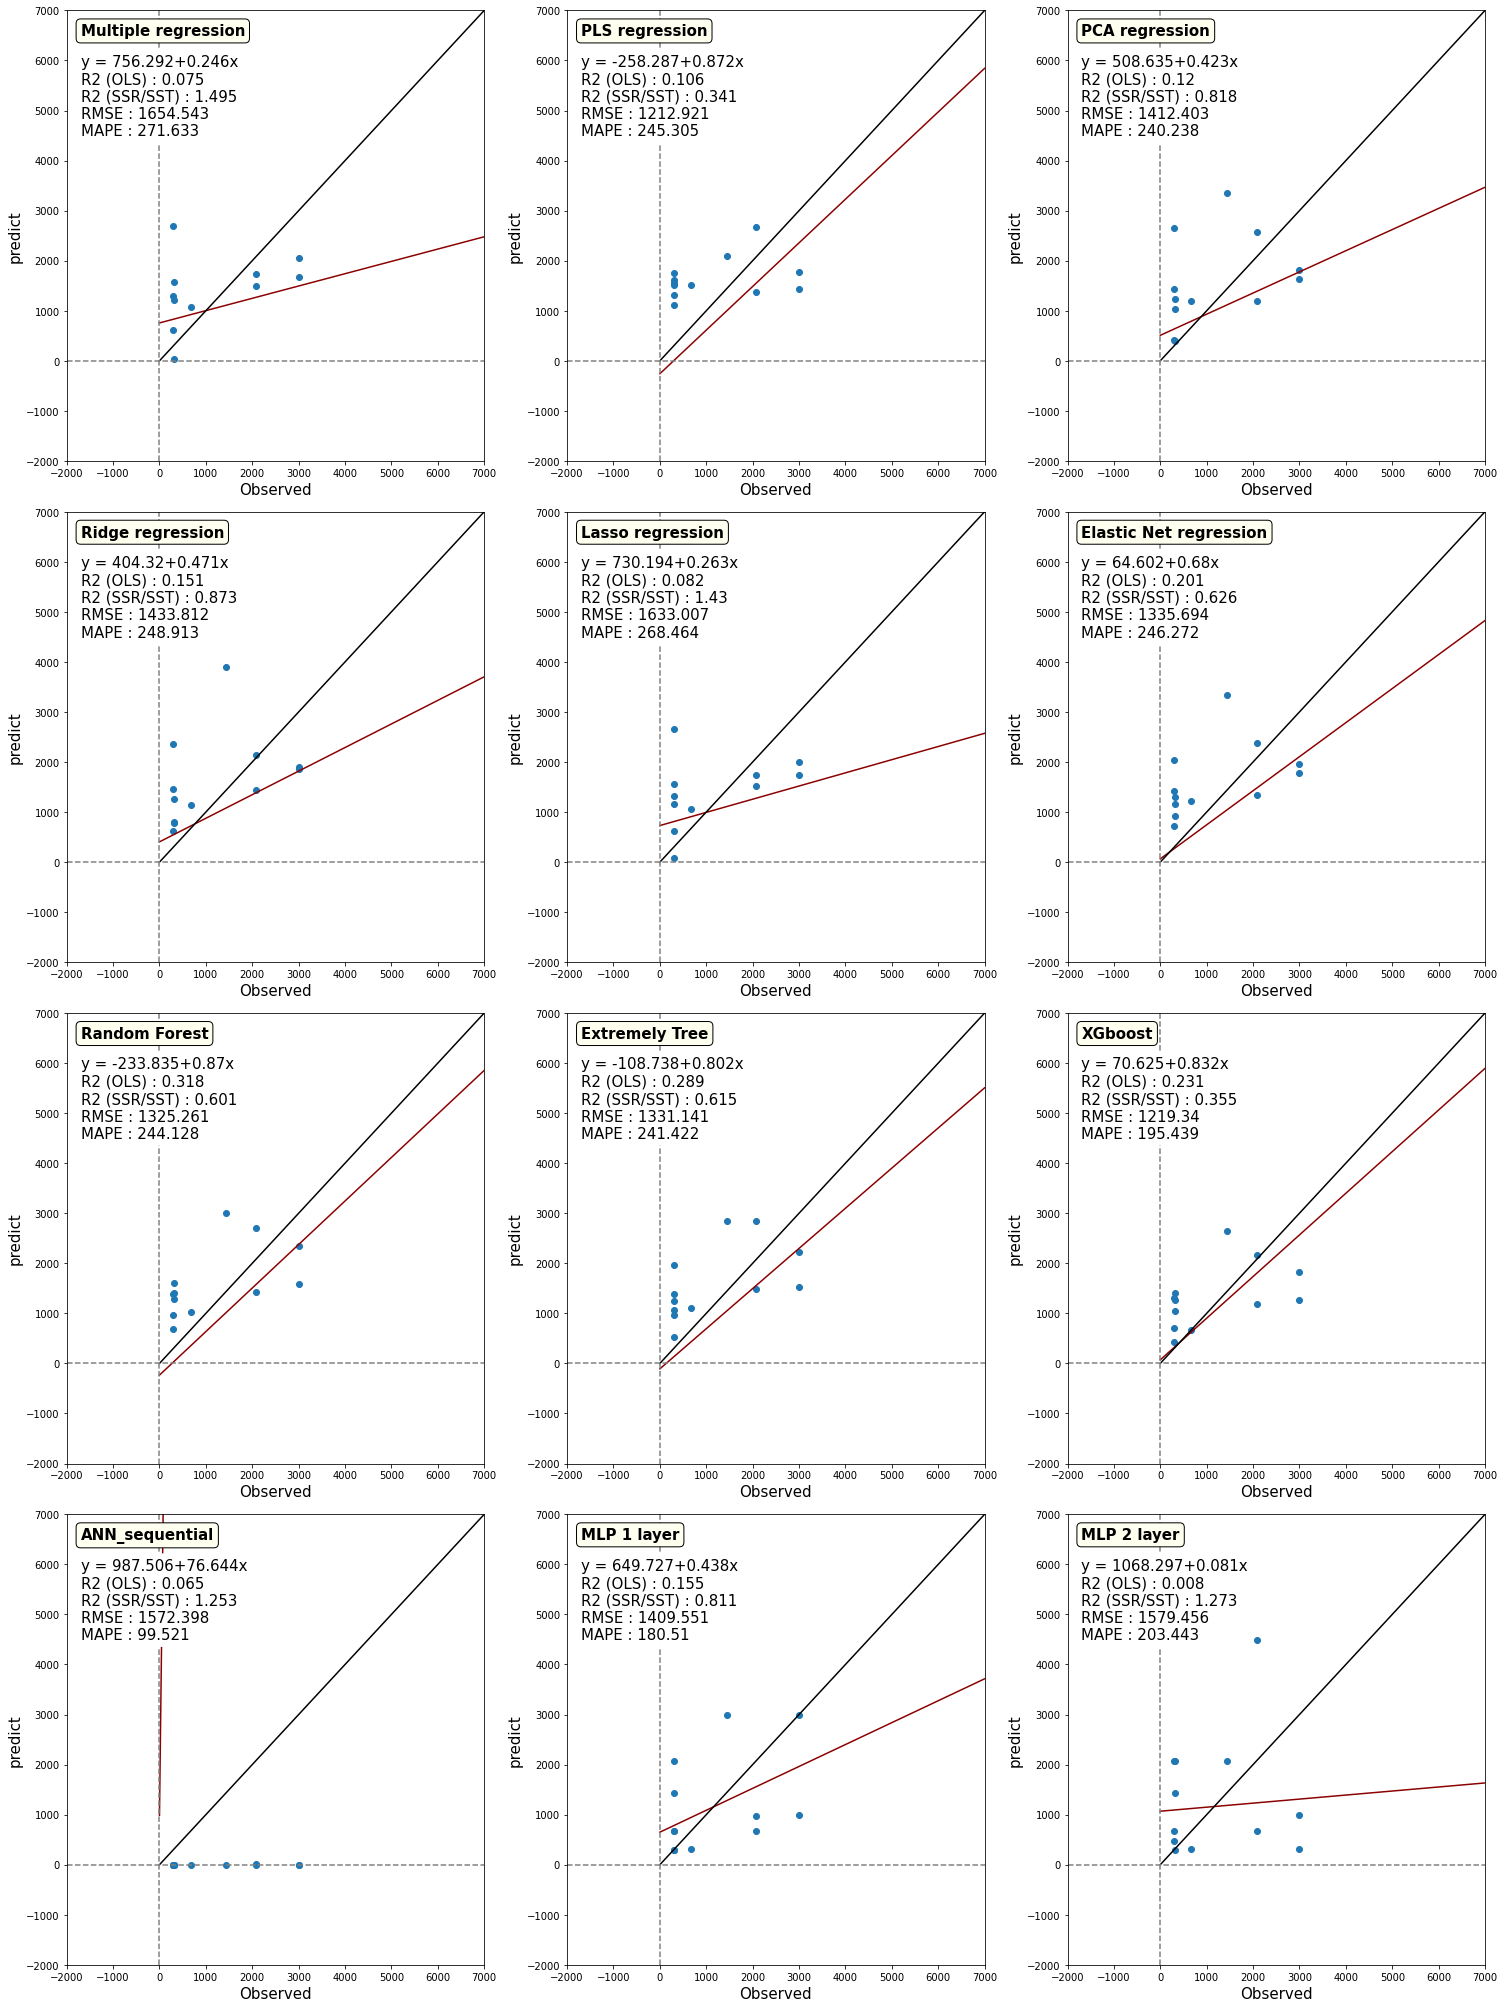

In [165]:
result = Analysis_odor(data = odor, test_size = 0.2, shuffle = "True", random_state = 99,
                       preprocess = "yes", log_y = "no",log_X = "no", epo = 100)

pred_list = [result["mr pred"], result["pls mr pred"], result["pca mr pred"],
              result["ridge pred"], result["lasso pred"], result["elasticnet pred"],
              result["rf pred"], result["et pred"], result["xg pred"],
              result["ann pred"], result["mlp1 pred"], result["mlp2 pred"]]

Plot_odor(test_y = result[test_y], pred_list = pred_list, log = "no")

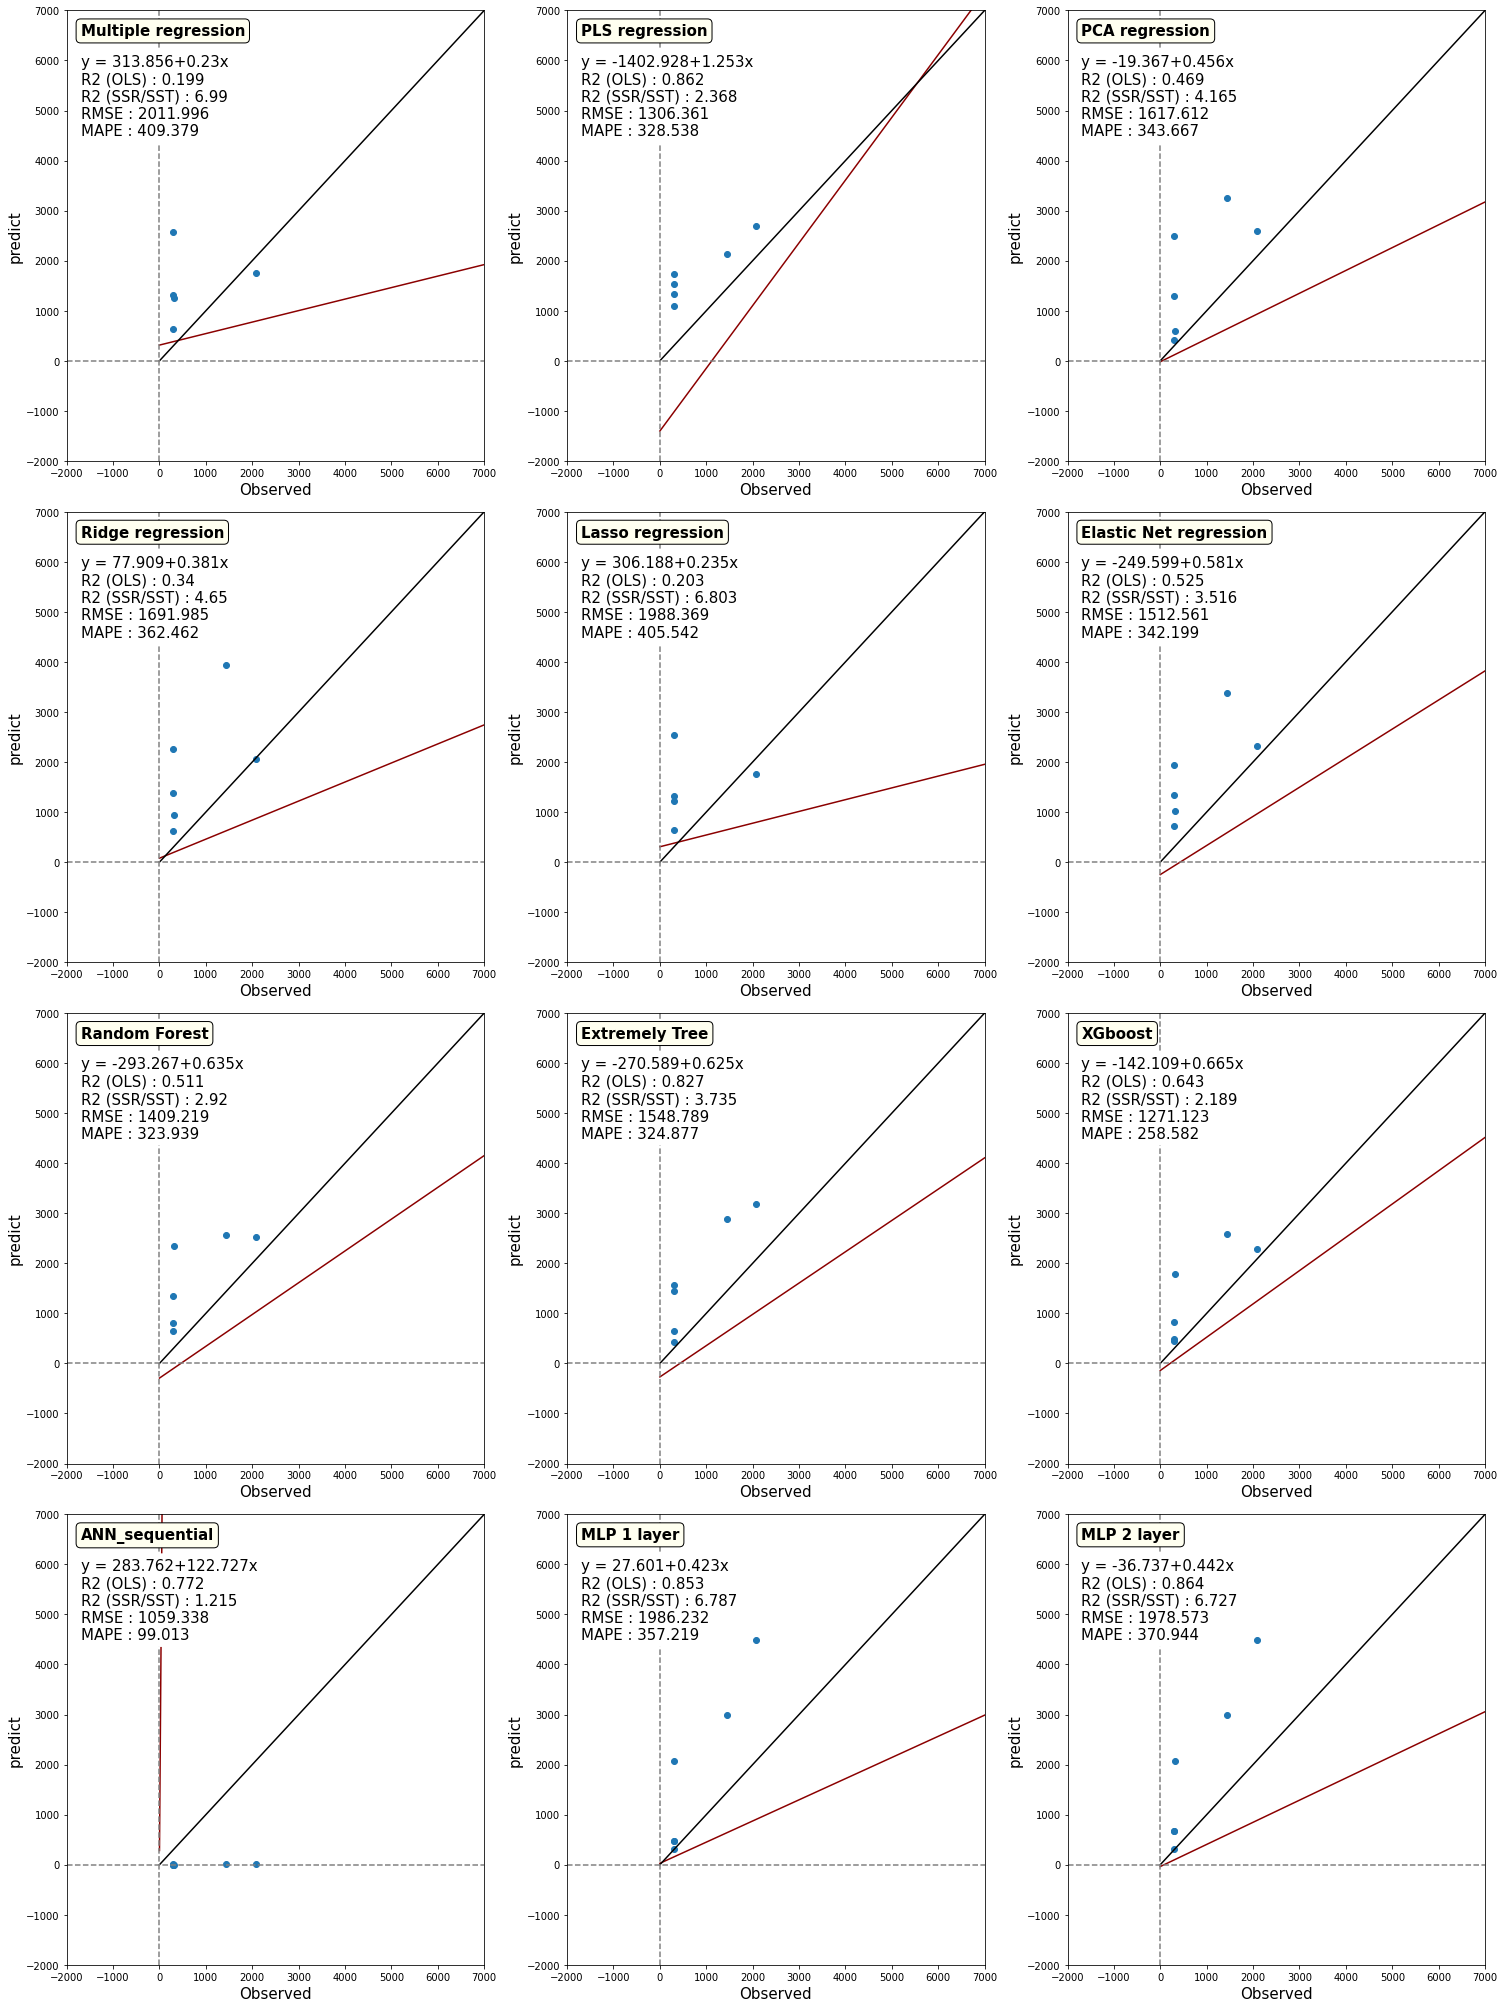

In [173]:
result = Analysis_odor(data = odor, test_size = 0.1, shuffle = "True", random_state = 99,
                       preprocess = "yes", log_y = "no",log_X = "no", epo = 100)

pred_list = [result["mr pred"], result["pls mr pred"], result["pca mr pred"],
              result["ridge pred"], result["lasso pred"], result["elasticnet pred"],
              result["rf pred"], result["et pred"], result["xg pred"],
              result["ann pred"], result["mlp1 pred"], result["mlp2 pred"]]

Plot_odor(test_y = result["test y"], pred_list = pred_list, log = "no")

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2021-11-03 08:51:59,331] A new study created in memory with name: no-name-3a9cff5b-d524-49ab-8207-2c80ce2a8283
[I 2021-11-03 08:52:02,535] Trial 0 finished with value: -0.8137351206943807 and parameters: {'n_estimators': 214, 'max_depth': 11, 'min_samples_leaf': 5, 'min_samples_split': 4}. Best is trial 0 with value: -0.8137351206943807.
[I 2021-11-03 08:52:06,388] Trial 1 finished with value: -0.8380378008042477 and parameters: {'n_estimators': 244, 'max_depth': 13, 'min_samples_leaf': 1, 'min_samples_split': 2}. Best is trial 0 with value: -0.8137351206943807.
[I 2021-11-03 08:52:09,274] Trial 2 finished with value: -0.8296892463196937 and parameters: {'n_estimators': 187, 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 2}. Best is trial 0 with value: -0.8137351206943807.
[I 2021-11-03 08:52:14,335] Trial 3 finished with value: -0.8112187953836048 and parameters: {'n_estimators': 338, 'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 2}. Best is trial 3 with

[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:07,385] Trial 31 finished with value: -1.0737369799318313 and parameters: {'n_estimators': 280, 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 5}. Best is trial 21 with value: -0.7570538989438962.


[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:07,573] Trial 32 finished with value: -1.073134635367118 and parameters: {'n_estimators': 226, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 21 with value: -0.7570538989438962.



[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of r

[I 2021-11-03 08:54:07,756] Trial 33 finished with value: -1.072775237204609 and parameters: {'n_estimators': 327, 'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 5}. Best is trial 21 with value: -0.7570538989438962.


[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:07,906] Trial 34 finished with value: -1.0728559550791812 and parameters: {'n_estimators': 164, 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 21 with value: -0.7570538989438962.


[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:08,083] Trial 35 finished with value: -1.0739845611597942 and parameters: {'n_estimators': 273, 'max_depth': 19, 'min_samples_leaf': 3, 'min_samples_split': 5}. Best is trial 21 with value: -0.7570538989438962.
[I 2021-11-03 08:54:08,264] Trial 36 finished with value: -1.0727937747471898 and parameters: {'n_estimators': 325, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 6}. Best is trial 21 with value: -0.7570538989438962.


[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:08,436] Trial 37 finished with value: -1.0731627819162015 and parameters: {'n_estimators': 231, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 21 with value: -0.7570538989438962.


[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:08,645] Trial 38 finished with value: -1.0730686183375964 and parameters: {'n_estimators': 374, 'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 5}. Best is trial 21 with value: -0.7570538989438962.


[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:08,815] Trial 39 finished with value: -1.073876029807689 and parameters: {'n_estimators': 248, 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 21 with value: -0.7570538989438962.


[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:08,991] Trial 40 finished with value: -1.0734347111427298 and parameters: {'n_estimators': 286, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}. Best is trial 21 with value: -0.7570538989438962.


[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:09,176] Trial 41 finished with value: -1.073311216609383 and parameters: {'n_estimators': 304, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 21 with value: -0.7570538989438962.


[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:09,378] Trial 42 finished with value: -1.073800869125686 and parameters: {'n_estimators': 397, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 21 with value: -0.7570538989438962.


[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[I 2021-11-03 08:54:09,575] Trial 43 finished with value: -1.072953675172962 and parameters: {'n_estimators': 318, 'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 21 with value: -0.7570538989438962.
[I 2021-11-03 08:54:09,765] Trial 44 finished with value: -1.0731100562248692 and parameters: {'n_estimators': 343, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 6}. Best is trial 21 with value: -0.7570538989438962.


[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:54:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

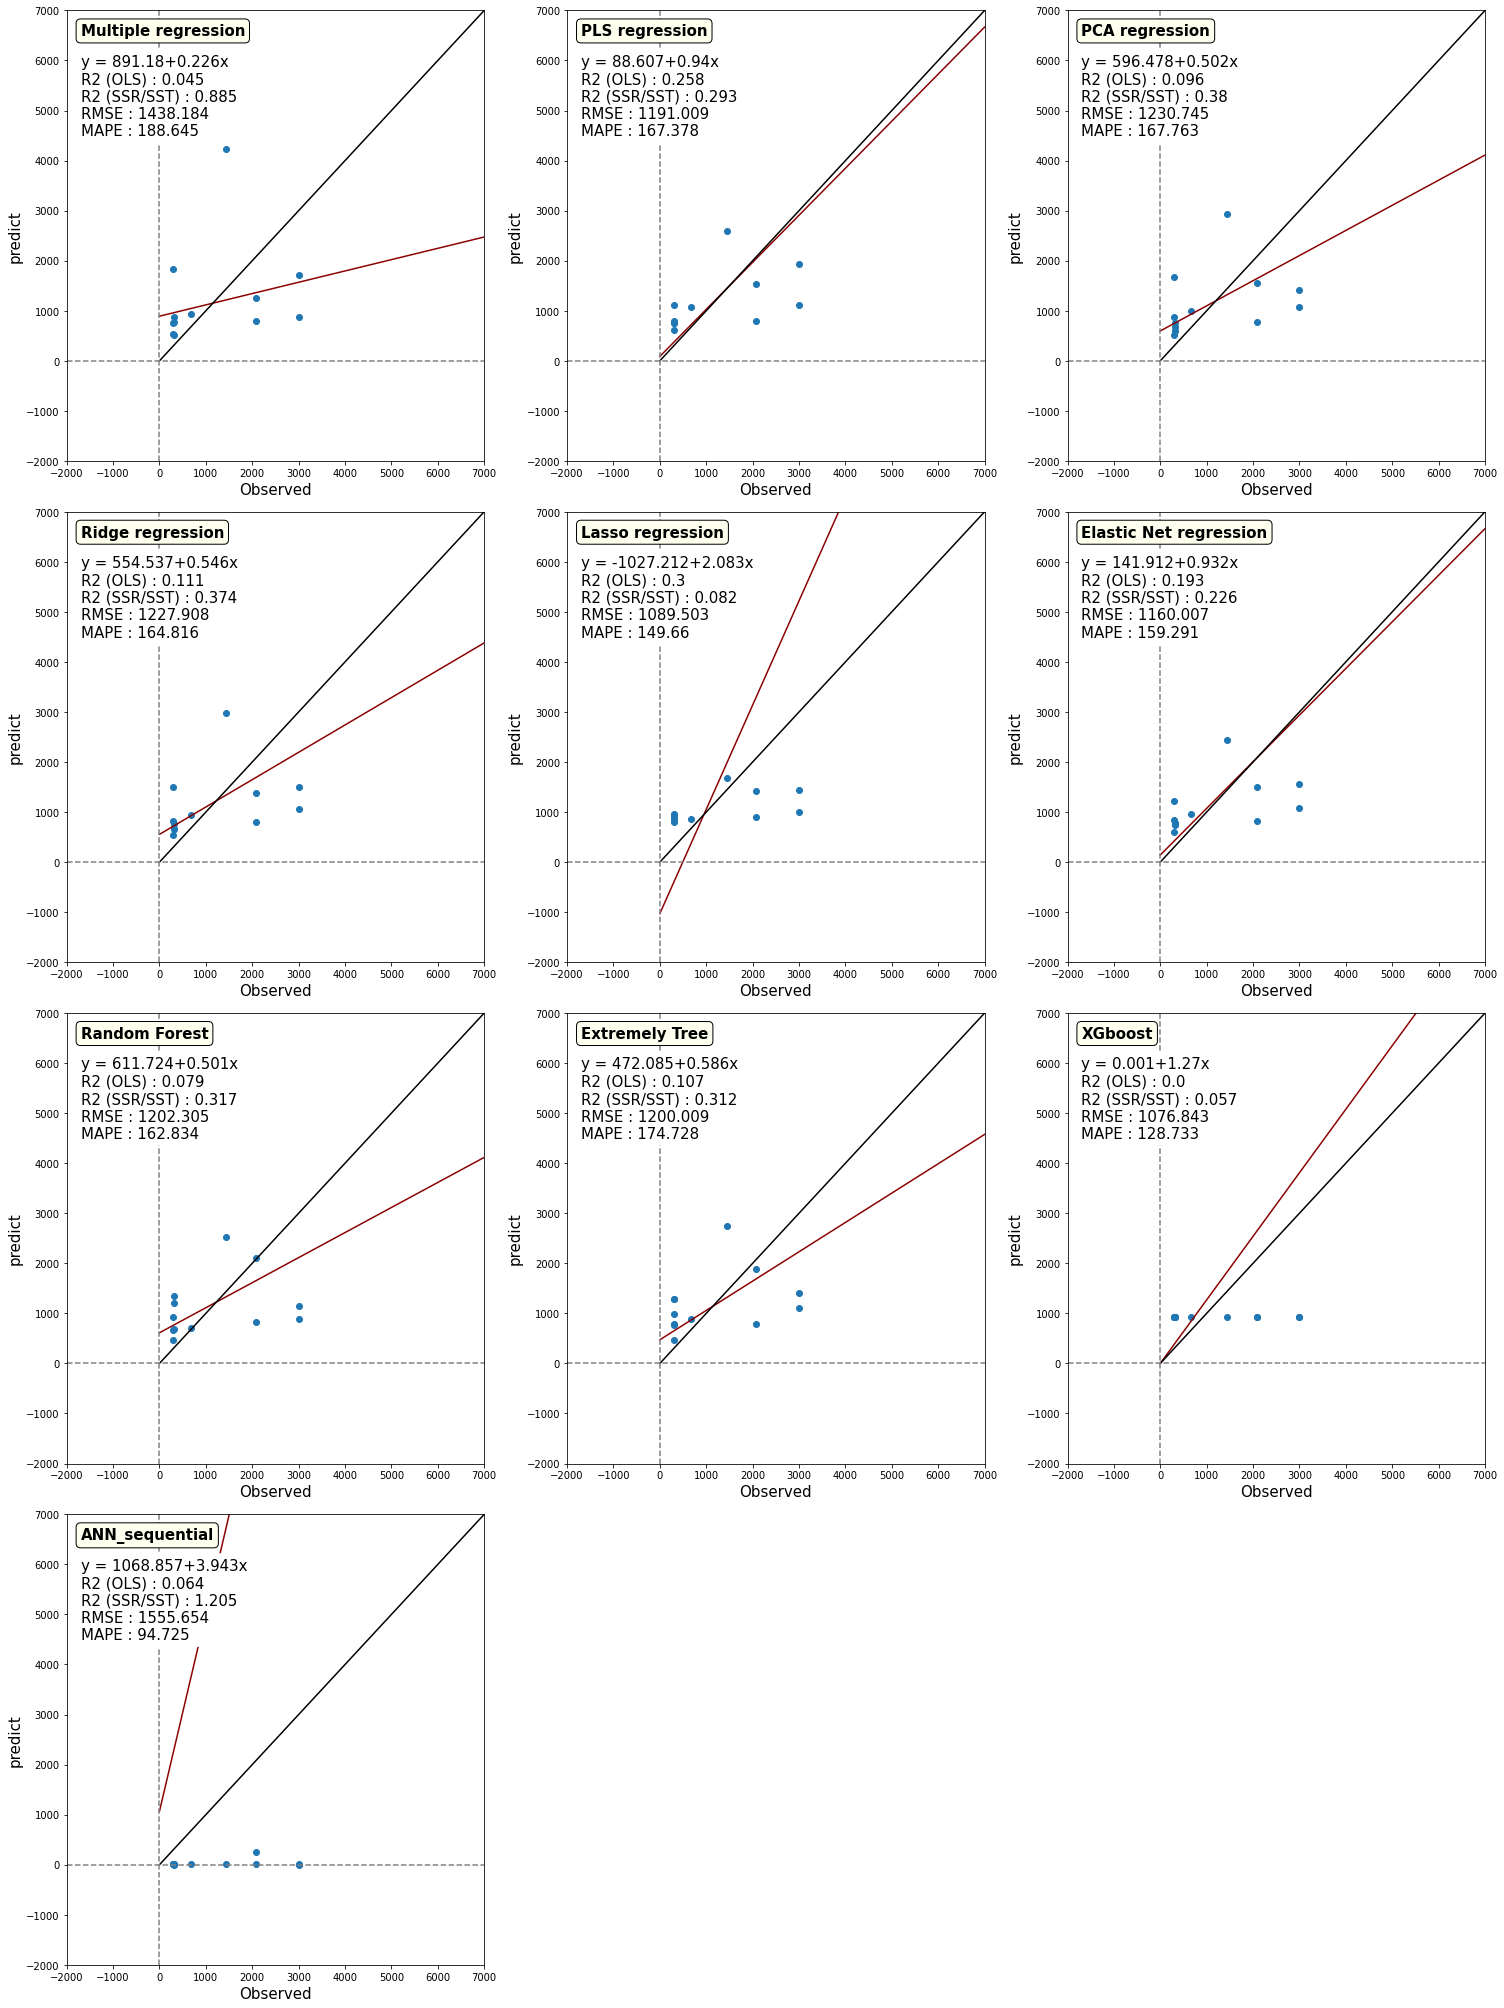

In [230]:
result = Analysis_odor(data = odor, test_size = 0.2, shuffle = "True", random_state = 99,
                       preprocess = "yes", log_y = "no",log_X = "yes", epo = 100)

pred_list = [result["mr pred"], result["pls mr pred"], result["pca mr pred"],
              result["ridge pred"], result["lasso pred"], result["elasticnet pred"],
              result["rf pred"], result["et pred"], result["xg pred"],``
              result["ann pred"]]

Plot_odor(test_y = result["test y"], pred_list = pred_list, log = "yes")

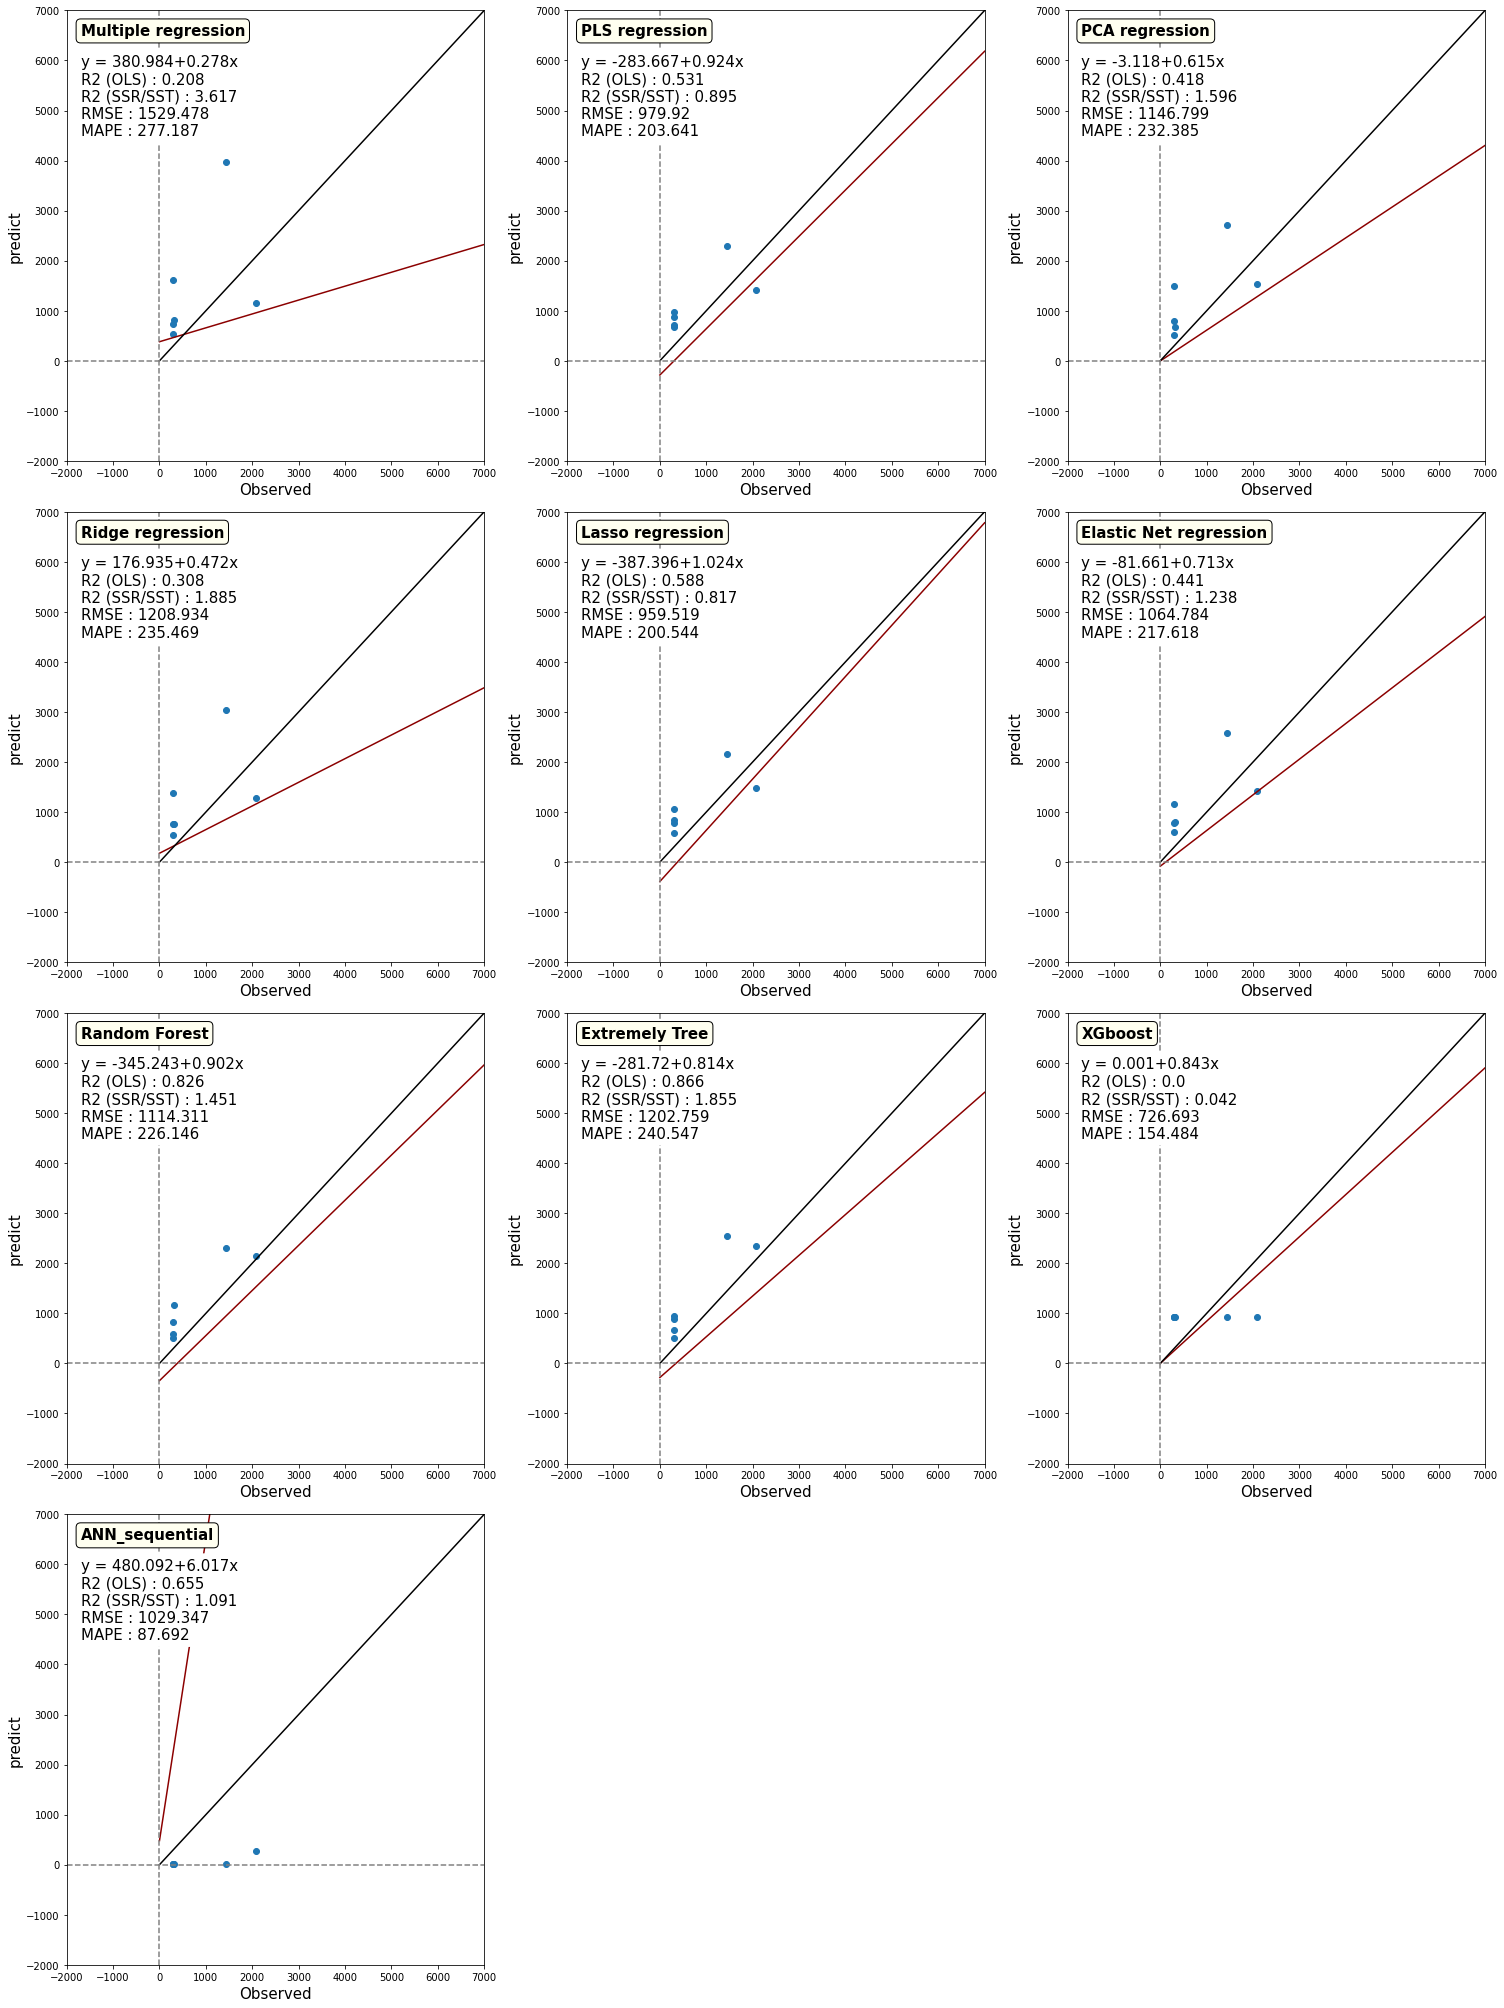

In [229]:
result = Analysis_odor(data = odor, test_size = 0.1, shuffle = "True", random_state = 99,
                       preprocess = "yes", log_y = "no",log_X = "yes", epo = 100)

pred_list = [result["mr pred"], result["pls mr pred"], result["pca mr pred"],
              result["ridge pred"], result["lasso pred"], result["elasticnet pred"],
              result["rf pred"], result["et pred"], result["xg pred"],
              result["ann pred"]]

Plot_odor(test_y = result["test y"], pred_list = pred_list, log = "yes")